In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import nltk
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [106]:
songData = pd.read_pickle('songData.df')
songData = songData.sort_values(by=['released'])

In [68]:
labMT = pd.read_csv('../Hedonometer.csv', index_col='Rank')

In [157]:
def idf(term: str, docs: {int: {str}}, log=np.log2):
    n = len(docs.keys())
    d = sum(term in doc for doc in docs.values())
    return log(n/d)

class MyColorFunctor():
    def __init__(self, tfidf):
        self.tfidf = tfidf
        self.high = max(tfidf.values())
        self.low = min(tfidf.values())

    def scale(self, x):
        return 260 - (x - self.low)/(self.high - self.low) * 200

    def __call__(self,word,font_size,position,orientation,random_state=None,**kwargs):
        return "hsl(%d, 80%%, %d%%)" % (self.scale(self.tfidf[word]), 50)

def text_happiness_score(token_list):
    text = [w for w in token_list if w in labMT['Word'].values]
    fdist = nltk.FreqDist(text)
    return sum([labMT['Happiness Score'][labMT['Word'] == w].item() * fdist.freq(w) for w in set(text)])

def lexical_diversity(text):
    return len(set(text)) / len(text)

### Preprocessing the lyrics

In [153]:
Stopwords = set(w for w in stopwords.words('english'))
lem_fun = WordNetLemmatizer()

all_tokens = []
all_tokens_repeat = []
for t in songData.lyrics:
    tokens = list(lem_fun.lemmatize(token.lower()) for token in nltk.word_tokenize(t) if token.isalpha() and lem_fun.lemmatize(token.lower()) not in Stopwords)
    all_tokens_repeat.append(tokens)
    all_tokens.append(list(set(tokens)))

In [154]:
songData['tokens'] = all_tokens
songData['tokens_repeat'] = all_tokens_repeat

## =======================   Genre   =======================

In [111]:
genre_count = defaultdict(lambda: 0)

for genres in songData.genres:
    for genre in genres:
        genre_count[genre] += 1

# Handpick genres
top_genres = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul',
              'singer-songwriter', 'trap', 'ballad', 'uk',
             'hip-hop', 'funk', 'dance', 'electronic', 'folk',
             'jazz', 'blues']
N = len(top_genres)

# Choose top N genres containing most songs
# N = 20
# top_genres = set([k for k, v in sorted(genre_count.items(), key=lambda item: item[1], reverse=True)][:N])

In [112]:
genre_docs = defaultdict(lambda: [])

for tokens, genres in zip(songData.tokens, songData.genres):
    for genre in genres:
        genre_docs[genre] += tokens

top_genre_docs = {genre: doc for genre, doc in genre_docs.items() if genre in top_genres}

In [113]:
for genre, doc in top_genre_docs.items():
    print('='*50)
    print(genre)
    fdist = nltk.FreqDist(doc)
    N = len(doc)
    for word, count in fdist.most_common(5):
        print(f'     Occurrence of {word:<10}: {count/N}')
    print('')

pop
     Occurrence of know      : 0.010017684782595319
     Occurrence of love      : 0.009902001444811048
     Occurrence of oh        : 0.007727400829228011
     Occurrence of like      : 0.007680635224591816
     Occurrence of got       : 0.007155137509337738

folk
     Occurrence of know      : 0.008472360232205428
     Occurrence of like      : 0.00789707651273469
     Occurrence of time      : 0.0065373149939856705
     Occurrence of wa        : 0.0064327179540818995
     Occurrence of love      : 0.006275822394226243

blues
     Occurrence of know      : 0.009710982658959538
     Occurrence of oh        : 0.009595375722543353
     Occurrence of love      : 0.008323699421965317
     Occurrence of got       : 0.008208092485549132
     Occurrence of baby      : 0.008208092485549132

r&b
     Occurrence of know      : 0.00965643675281669
     Occurrence of love      : 0.008948995405760279
     Occurrence of oh        : 0.008280091719633011
     Occurrence of baby      : 0.007991059

In [114]:
top_genre_docs_set = {decade: set(doc) for decade, doc in top_genre_docs.items()}

all_terms = set()
for doc in top_genre_docs.values():
    all_terms = all_terms.union(set(doc))

idf_dict = {t: idf(t, top_genre_docs_set) for t in all_terms}

In [115]:
for genre, doc in top_genre_docs.items():
    print('='*50)
    print(genre)

    fdist = nltk.FreqDist(doc)
    N = len(doc)

    stock_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
    tfidf_keys = [k[0] for k in sorted(stock_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]]

    print(f'{"TF":>14} {"TFIDF":>25}')
    i = 1
    for (tf_word, _), iftdf_word in zip(fdist.most_common(10), tfidf_keys[:10]):
        print(f'{str(i)+".":<4} {tf_word:<8} {_/N:.4f} {iftdf_word:>17} {stock_tfidf[iftdf_word]:.5f}')
        i += 1
    print('')

pop
            TF                     TFIDF
1.   know     0.0100            chorus 0.00008
2.   love     0.0099     miscellaneous 0.00006
3.   oh       0.0077            broken 0.00006
4.   like     0.0077             party 0.00005
5.   got      0.0072          breaking 0.00005
6.   time     0.0070           breathe 0.00005
7.   go       0.0066           rainbow 0.00005
8.   one      0.0063            happen 0.00005
9.   na       0.0062             nigga 0.00005
10.  see      0.0062              fear 0.00005

folk
            TF                     TFIDF
1.   know     0.0085      annihilation 0.00032
2.   like     0.0079        squandered 0.00026
3.   time     0.0065            ragged 0.00024
4.   wa       0.0064             birch 0.00022
5.   love     0.0063            sunlit 0.00022
6.   one      0.0057            knowed 0.00022
7.   come     0.0056         blindness 0.00018
8.   go       0.0055         hitchhike 0.00018
9.   say      0.0052        suppertime 0.00018
10.  day      0

### Wordcloud

In [116]:
genre_ims = {genre: np.array(Image.open(f"../{genre}.jpg")) for genre in top_genre_docs.keys() if genre == 'rap'}

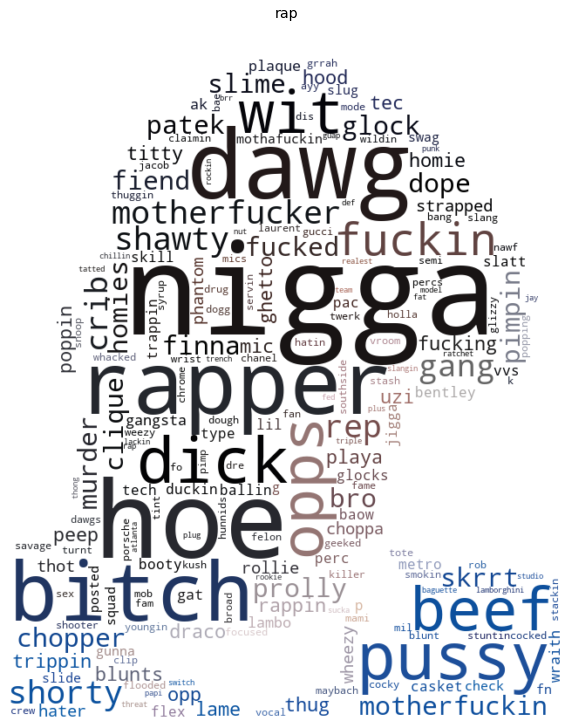

In [117]:
# n_decades = len(decade_docs.keys())

# gs = gridspec.GridSpec(2, n_decades+1)
for i, genre in enumerate(genre_ims.keys()):
    fdist = nltk.FreqDist(genre_docs[genre])
    decade_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(genre_docs[genre])}
    wc = WordCloud(background_color='white', mask=genre_ims[genre]) # , color_func=MyColorFunctor(decade_tfidf)
    wc.generate_from_frequencies(decade_tfidf)
    image_colors = ImageColorGenerator(genre_ims[genre])
#     if i < ((n_decades+1)//2):
#         ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
#     else:
#         ax = plt.subplot(gs[1, 2 * i - n_decades:2 * i + 2 - n_decades])
    plt.figure(figsize=(10,15))
    plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    plt.title(genre, size='x-large')
    plt.axis("off")
    plt.show()

### Sentiment analysis

In [70]:
genre_happiness = {}

for genre, doc in top_genre_docs.items():
    genre_happiness[genre] = text_happiness_score(doc)
    print(genre, end=' ')

country pop rock jazz r&b rap uk soul singer-songwriter folk hip-hop blues funk ballad trap dance electronic 

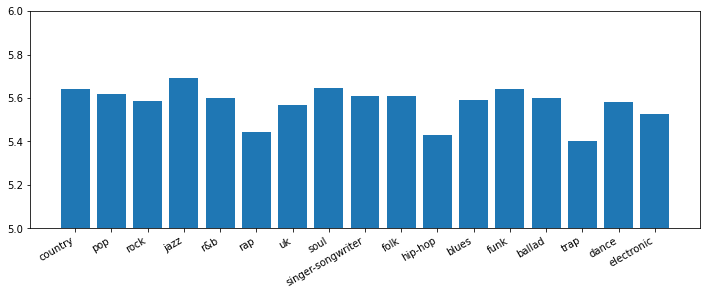

In [84]:
plt.figure(figsize=(12,4))
plt.bar(*zip(*genre_happiness.items()))
plt.xticks(rotation=30, ha='right')
plt.ylim(5,6)
plt.show()

### Lexical diversity

In [155]:
genre_docs_repeat = defaultdict(lambda: [])

for tokens, genres in zip(songData.tokens_repeat, songData.genres):
    for genre in genres:
        if genre in top_genres:
            genre_docs_repeat[genre] += tokens

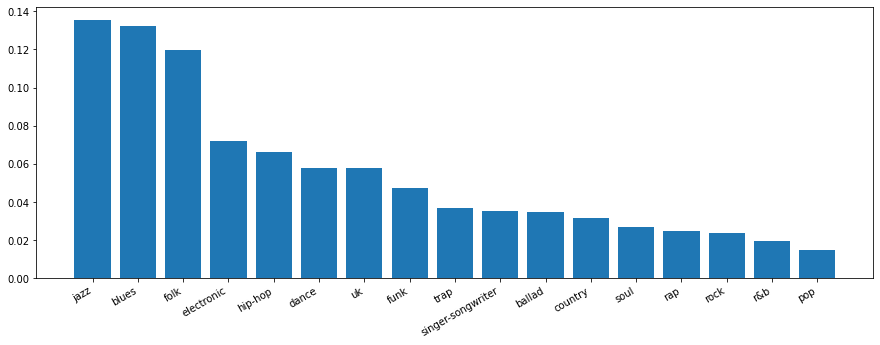

In [175]:
genre_lexi = {genre: lexical_diversity(doc) for genre, doc in genre_docs_repeat.items()}

genre_lexi = {k: v for k, v in sorted(genre_lexi.items(), key=lambda item: item[1], reverse=True)}
plt.figure(figsize=(15,5))
plt.bar(*zip(*genre_lexi.items()))
plt.xticks(rotation=30, ha='right')
plt.show()

### Dispersion plot

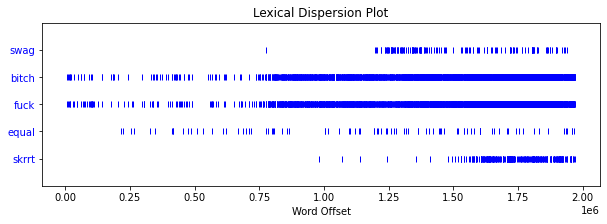

In [149]:
all_tokens = []
for tokens in songData.tokens:
    all_tokens += tokens

words = nltk.Text(all_tokens)
plt.figure(figsize=(10,3))
words.dispersion_plot(['swag', 'bitch', 'fuck', 'equal', 'skrrt'])

pop


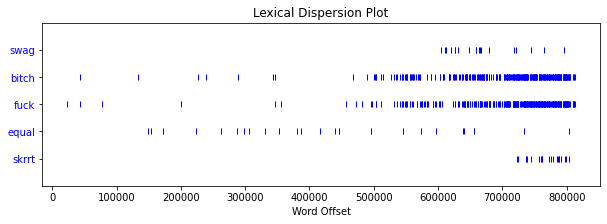

folk


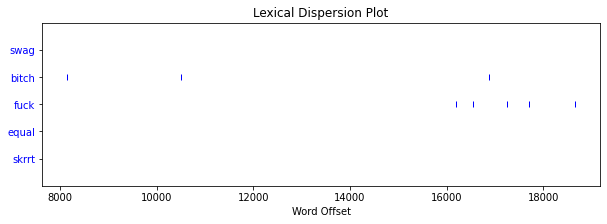

blues


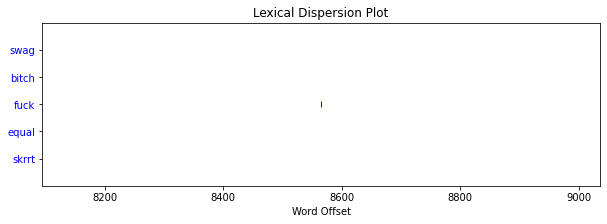

r&b


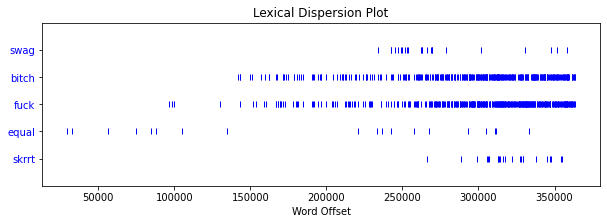

jazz


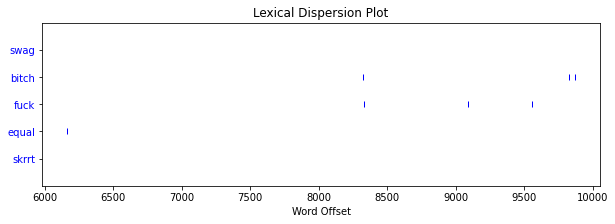

country


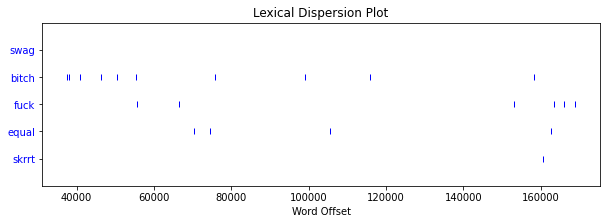

rock


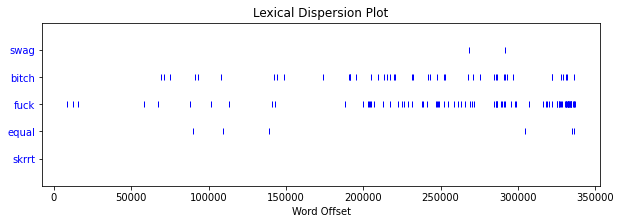

singer-songwriter


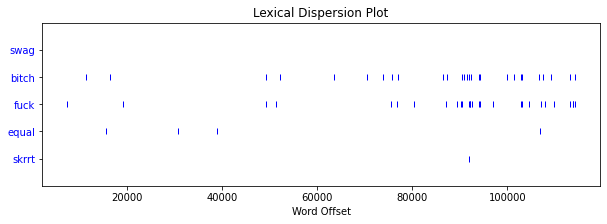

soul


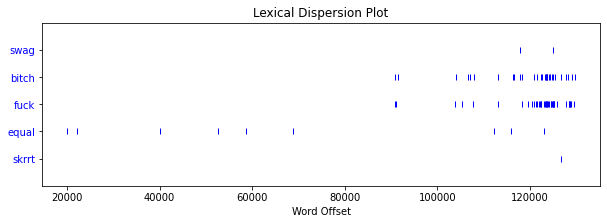

rap


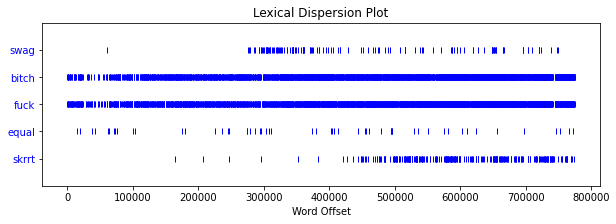

ballad


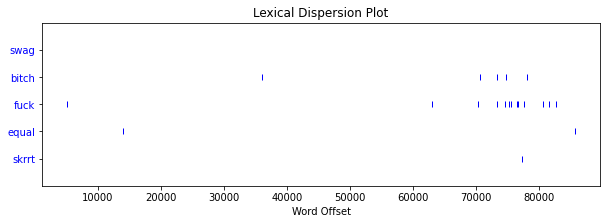

funk


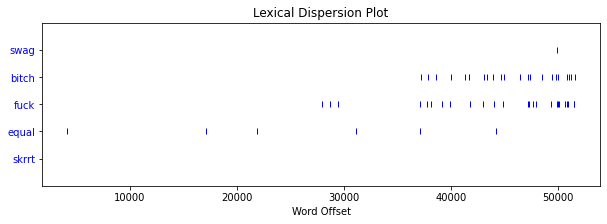

uk


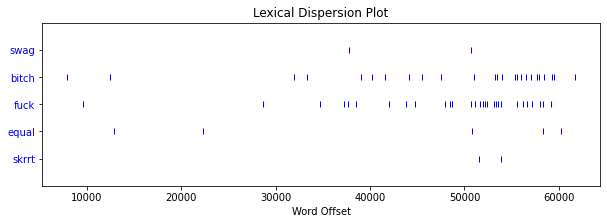

trap


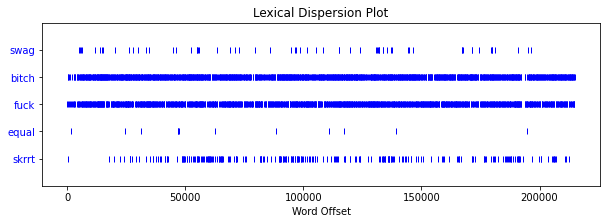

dance


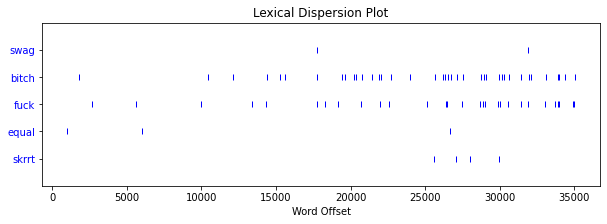

hip-hop


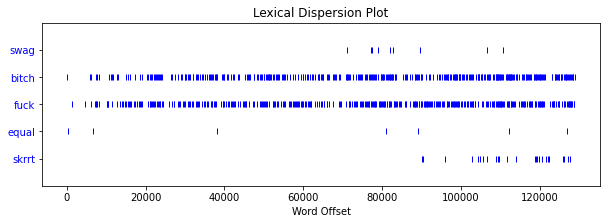

electronic


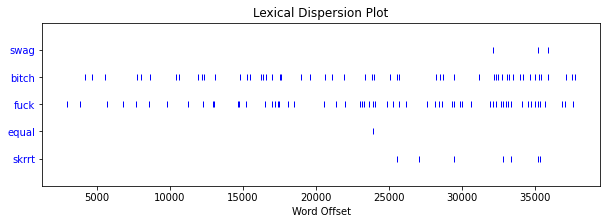

In [152]:
for genre, doc in top_genre_docs.items():
    words = nltk.Text(doc)
    print('='*100)
    print(genre)
    plt.figure(figsize=(10,3))
    words.dispersion_plot(['swag', 'bitch', 'fuck', 'equal', 'skrrt'])
    plt.show()

## =======================   Decade   =======================

In [11]:
decade_docs = defaultdict(lambda: [])

for tokens, release in zip(songData.tokens, songData.released):
    decade = max(int(int(release[:4]) / 10) * 10, 1960)
    decade_docs[decade] += tokens

decade_docs = {k: v for k, v in sorted(decade_docs.items(), key=lambda item: int(item[0]))}

In [12]:
for decade, doc in decade_docs.items():
    print('='*50)
    print(decade)
    fdist = nltk.FreqDist(doc)
    N = len(doc)
    for word, count in fdist.most_common(5):
        print(f'     Occurrence of {word:<10}: {count/N}')
    print('')

1960
     Occurrence of love      : 0.012231131267486154
     Occurrence of know      : 0.010281654526619739
     Occurrence of oh        : 0.008303628963188333
     Occurrence of go        : 0.006876187834938864
     Occurrence of got       : 0.006855795818821015

1970
     Occurrence of know      : 0.009869426978388636
     Occurrence of love      : 0.009785645764650193
     Occurrence of got       : 0.007862866909352915
     Occurrence of oh        : 0.007841921605918305
     Occurrence of like      : 0.007280587473870734

1980
     Occurrence of know      : 0.009988930589060247
     Occurrence of love      : 0.009764014271160876
     Occurrence of time      : 0.007801509144391866
     Occurrence of got       : 0.007444289110081102
     Occurrence of oh        : 0.007192912048899453

1990
     Occurrence of know      : 0.007627508262832278
     Occurrence of love      : 0.006599405582887159
     Occurrence of like      : 0.0063822007913494575
     Occurrence of time      : 0.0059550

In [13]:
N = len(decade_docs.keys())

decade_docs_set = {decade: set(doc) for decade, doc in decade_docs.items()}

all_terms = set()
for doc in decade_docs.values():
    all_terms = all_terms.union(set(doc))

idf_dict = {t: idf(t, decade_docs_set) for t in all_terms}

In [14]:
for decade, doc in decade_docs.items():
    print('='*50)
    print(decade)

    fdist = nltk.FreqDist(doc)
    N = len(doc)

    stock_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
    tfidf_keys = [k[0] for k in sorted(stock_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]]

    print(f'{"TF":>14} {"TFIDF":>25}')
    i = 1
    for (tf_word, _), iftdf_word in zip(fdist.most_common(10), tfidf_keys[:10]):
        print(f'{str(i)+".":<4} {tf_word:<8} {_/N:.4f} {iftdf_word:>17} {stock_tfidf[iftdf_word]:.5f}')
        i += 1
    print('')

1960
            TF                     TFIDF
1.   love     0.0122            watusi 0.00011
2.   know     0.0103          tenderly 0.00009
3.   oh       0.0083             looka 0.00007
4.   go       0.0069            sighin 0.00007
5.   got      0.0069             hully 0.00006
6.   like     0.0068            billow 0.00006
7.   come     0.0067             rovin 0.00006
8.   one      0.0066            fickle 0.00005
9.   baby     0.0065             twine 0.00005
10.  time     0.0064           doggone 0.00005

1970
            TF                     TFIDF
1.   know     0.0099            nigger 0.00006
2.   love     0.0098           doggone 0.00005
3.   got      0.0079        gentleness 0.00005
4.   oh       0.0078              toad 0.00004
5.   like     0.0073            unkind 0.00004
6.   time     0.0071               uum 0.00004
7.   get      0.0065          marianne 0.00004
8.   come     0.0063           crowing 0.00004
9.   go       0.0062            salina 0.00004
10.  na       

### Word cloud

In [49]:
decade_ims = {decade: np.array(Image.open(f"../{decade}.png")) for decade in decade_docs.keys()}

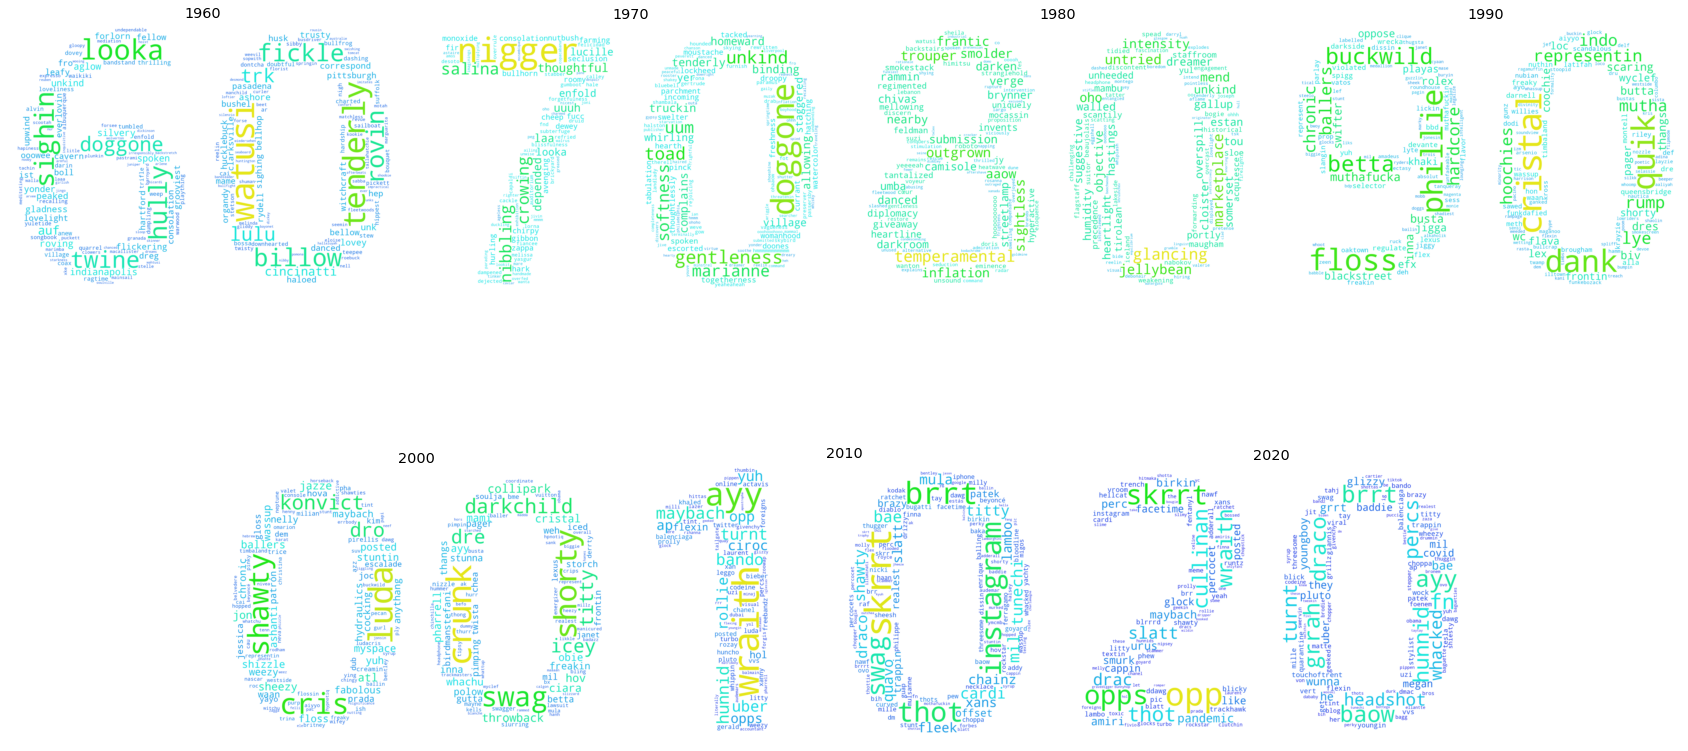

In [47]:
n_decades = len(decade_docs.keys())
plt.figure(figsize=(30,15))
gs = gridspec.GridSpec(2, n_decades+1)
for i, (decade, doc) in enumerate(decade_docs.items()):
    fdist = nltk.FreqDist(doc)
    decade_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
    wordcloud = WordCloud(background_color='white', mask=decade_ims[decade], color_func=MyColorFunctor(decade_tfidf))
    wordcloud.generate_from_frequencies(decade_tfidf)
    
    if i < ((n_decades+1)//2):
        ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
    else:
        ax = plt.subplot(gs[1, 2 * i - n_decades:2 * i + 2 - n_decades])
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(decade, size='x-large')
    plt.axis("off")
plt.show()

### Sentiment analysis

In [66]:
decade_happiness = {}

for decade, doc in decade_docs.items():
    decade_happiness[decade] = text_happiness_score(doc)
    print(decade, end=' ')

1960 1970 1980 1990 2000 2010 2020 

In [67]:
plt.figure(figsize=(12,4))
plt.bar(*zip(*decade_happiness.items()))
plt.xticks(rotation=30, ha='right')
plt.ylim(5,6)
plt.show()

{1960: 5.653644708709559,
 1970: 5.667815146426225,
 1980: 5.604704215573121,
 1990: 5.543409526642222,
 2000: 5.535554258525407,
 2010: 5.49120864337768,
 2020: 5.427076590096197}

### Lexical diversity

In [170]:
decade_docs_repeat = defaultdict(lambda: [])

for tokens, release in zip(songData.tokens, songData.released):
    decade = max(int(int(release[:4]) / 10) * 10, 1960)
    decade_docs_repeat[decade] += tokens

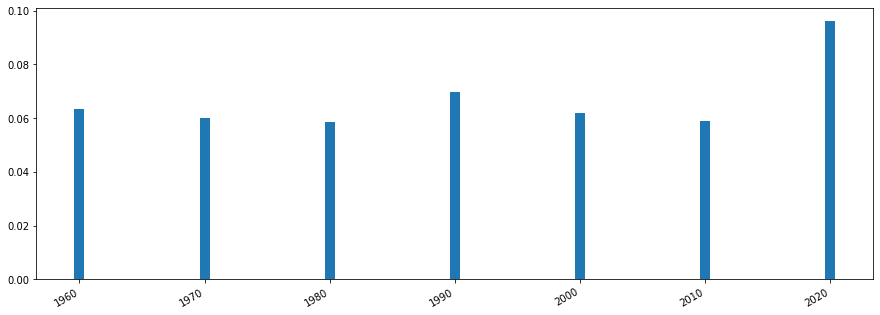

In [172]:
decade_lexi = {decade: lexical_diversity(doc) for decade, doc in decade_docs_repeat.items()}

decade_lexi = {k: v for k, v in sorted(decade_lexi.items(), key=lambda item: item[1], reverse=True)}
plt.figure(figsize=(15,5))
plt.bar(*zip(*decade_lexi.items()))
plt.xticks(rotation=30, ha='right')
plt.show()

# Year

### Sentiment

# Artist

In [178]:
artist_count = defaultdict(lambda: 0)

for artists in songData.artists:
    for artist in artists:
        artist_count[artist] += 1
artist_count = {k: v for k, v in sorted(artist_count.items(), key=lambda item: item[1], reverse=True)}

In [182]:
artist_docs = defaultdict(lambda: [])

for tokens, artist in zip(songData.tokens, songData.artists):
    for artist in artists:
        artist_docs[genre] += tokens

top_artist_docs = {artist: doc for artist, doc in artist_docs.items() if genre in top_genres}

[('drake', 253),
 ('lil wayne', 169),
 ('taylor swift', 161),
 ('kanye west', 132),
 ('future', 126),
 ('nicki minaj', 111),
 ('chris brown', 102),
 ('justin bieber', 97),
 ('lil baby', 97),
 ('jay-z', 95),
 ('the weeknd', 92),
 ('elvis presley', 89),
 ('eminem', 89),
 ('lil uzi vert', 80),
 ('youngboy never broke again', 79),
 ('travis scott', 76),
 ('lil durk', 71),
 ('juice wrld', 70),
 ('young thug', 70),
 ('james brown', 69),
 ('aretha franklin', 68),
 ('ariana grande', 68),
 ('the beatles', 65),
 ('stevie wonder', 65),
 ('gunna', 65),
 ('elton john', 64),
 ('beyoncé', 63),
 ('meek mill', 62),
 ('the rolling stones', 58),
 ('kenny chesney', 57),
 ('dionne warwick', 56),
 ('tim mcgraw', 56),
 ('ludacris', 56),
 ('t.i.', 56),
 ('the beach boys', 55),
 ('rihanna', 55),
 ('ray charles', 54),
 ('r. kelly', 54),
 ('21 savage', 54),
 ('madonna', 53),
 ('big sean', 53),
 ('marvin gaye', 52),
 ('post malone', 52),
 ('usher', 51),
 ('j. cole', 51),
 ('the temptations', 50),
 ('cher', 50),
 

### Lexical diveristy